In [1]:
#%matplotlib qt

In [2]:
import numpy as np
#from  qsweepy.instrument_drivers import AWG500, Signal_Hound_SA, Labbrick
#from qsweepy.instrument_drivers.AWG500 import AWG500
#from qsweepy.instrument_drivers.Signal_Hound_SA import Signal_Hound_SA, get_signal_hounds
#from qsweepy.instrument_drivers.Labbrick import Labbrick


In [3]:
%matplotlib notebook

In [4]:
from qsweepy.instruments import *
#import qsweepy.awg_iq_multi
from scipy.signal import resample
from matplotlib import pyplot as plt

In [5]:
class awg_iq:
    def __init__(self, awg, channel_i, channel_q):
        self.awg = awg
        self.channel_i = channel_i
        self.channel_q = channel_q
    def get_nop(self):
        return self.awg.get_nop()
    def set_nop(self, nop):
        self.awg.set_nop(nop)
    def set_waveform(self, waveform):
        self.awg.set_waveform(np.real(waveform), channel= self.channel_i)
        self.awg.set_waveform(np.imag(waveform), channel= self.channel_q)
    def get_clock(self):
        return self.awg.get_clock()

In [6]:
def dft(waveforms):
    return np.fft.fftshift(np.fft.fft(waveforms, axis=1, norm='ortho'), axis=1)
def ift(psds):
    return np.fft.ifft(np.fft.ifftshift(psd, axis=1), axis=1, norm='ortho')

In [7]:
class iq_calibration_measure:
    def __init__(self, 
                 awg_iq,
                 sa, 
                 lo,
                 video_bw = 'keep',
                 repetition_rate = 'keep', 
                 res_bw = 'keep', 
                 algorithmic_resolution = 'keep',
                 random_waveforms=5,
                 low_amplitude=0.05):
        '''Collect data for iq mixer calibration with random waveforms.
        awg_iq: class with set_waveform and get_nop/set_nop methods
        sa: spectrum analyzer with set_bandwidth(), set_xlim() and measure() methods
        lo: local  oscillator with get_frequency() method
        measurement_resolution_bw: resolution bandwidth as installed on sa.
        repetition_rate: repetition rate of the AWG
        random_waveforms: number of different random segments for algorithm. 
        low_amplitude: waveform amplitude multiplier to make sure the linear regime is working

        A key issue for this method is frequency resolution. 
        The parameters should be, at least:
        4*repetition_rate<2*measurement_resolution_bw<algorithmic_resolution
        algorithmic_resolution is the effective frequency resolution of the reconstruction algorithms.
        '''
        self.awg_iq = awg_iq
        self.sa = sa
        self.lo = lo
        
        self.discretization_frequency = self.awg_iq.get_clock()
        self.lo_frequency = lo.get_frequency()
        
        if video_bw == 'keep': 
            self.video_bw = self.sa.get_video_bw()
        else: 
            self.video_bw = video_bw
            self.sa.set_video_bw(self.video_bw)
        
        if repetition_rate == 'keep': 
            self.awg_nop = self.awg_iq.get_nop()
        else: 
            self.awg_nop = int(self.discretization_frequency/repetition_rate)
            self.awg_iq.set_nop(self.awg_nop)
            
        if res_bw == 'keep': 
            self.res_bw = self.sa.get_res_bw()
        else: 
            self.res_bw = res_bw
            self.sa.set_res_bw(self.res_bw)
        self.low_amplitude = low_amplitude
        self.sa.set_video_bw(self.video_bw)
        
        # following parameters must be integer
        self.random_waveform_number = random_waveforms
        self.segment_length = int(self.discretization_frequency/algorithmic_resolution)
        self.half_physical_padding = int((self.awg_nop-self.segment_length)/2)
        self.half_simulation_padding = int(((self.discretization_frequency/self.res_bw)-self.segment_length)/2)
        
        self.frequency_step = self.discretization_frequency/self.segment_length
        if hasattr(sa, 'set_nop'):
            self.sa.set_nop(self.segment_length)
        self.sa.set_span(self.discretization_frequency-self.frequency_step)
        self.sa.set_centerfreq(self.lo_frequency-self.frequency_step/2)
        
    def generate_random_waveforms(self, seed=42):
        np.random.seed(seed)
        self.waveforms = (np.random.rand(self.random_waveform_number, self.segment_length)*2-1)*self.low_amplitude
    
    def measure(self):
        self.psds = np.zeros((random_waveform_number, self.segment_length))
        for random_waveform_id in range(self.waveforms.shape[0]):
            padded_waveform    = np.zeros((self.half_physical_padding*2+self.segment_length), dtype=np.complex)
            padded_waveform[self.half_physical_padding:-self.half_physical_padding] = self.waveforms[random_waveform_id,:]
            self.awg_iq.set_waveform(padded_waveform)
            psd = sa.measure()['Power']
            if not hasattr(sa, 'set_nop'):
                psd = resample(psd, self.segment_length)
            self.psds[random_waveform_id, :]  = psd

In [8]:
awg = AWG500('awg', address=2, ver=2)

opening device
device open
Virtex is programmed?  False


In [9]:
sa = Signal_Hound_SA('sa', serial=61660066)
sa.set_ref(-30)
sa.set_detector('rms')

In [10]:
lo = Labbrick('lo', serial=15248)


In [11]:
awg_iq_inst = awg_iq(awg=awg, channel_i=1, channel_q=2)

In [30]:
repetition_rate = 500e6/32576#100e3
#algorithmic_resolution = e6
video_bw = 10e3
res_bw = 0.25e6
algorithmic_resolution = 2.0e6
random_waveform_number = 5
low_amplitude = 0.4

In [31]:
iq_calibration_measure_inst = iq_calibration_measure(awg_iq=awg_iq_inst, 
                                                     sa=sa, 
                                                     lo=lo, 
                                                     video_bw=video_bw, 
                                                     repetition_rate=repetition_rate,
                                                     res_bw=res_bw,
                                                     algorithmic_resolution=algorithmic_resolution,
                                                     random_waveforms=5,
                                                     low_amplitude=0.05)

In [32]:
sa.get_span(), sa.get_centerfreq()

(497600224.91520005, 3998901807.5028005)

In [33]:
sa.get_res_bw()

250000.0

In [34]:
iq_calibration_measure_inst.generate_random_waveforms()

In [35]:
iq_calibration_measure_inst.measure()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

In [36]:
power = sa.measure()['Power']
power

array([3.73062124e-09, 3.59986837e-09, 3.35913586e-09, ...,
       3.32942614e-09, 3.15345155e-09, 3.11926394e-09])

In [39]:
f= sa.get_freqpoints()

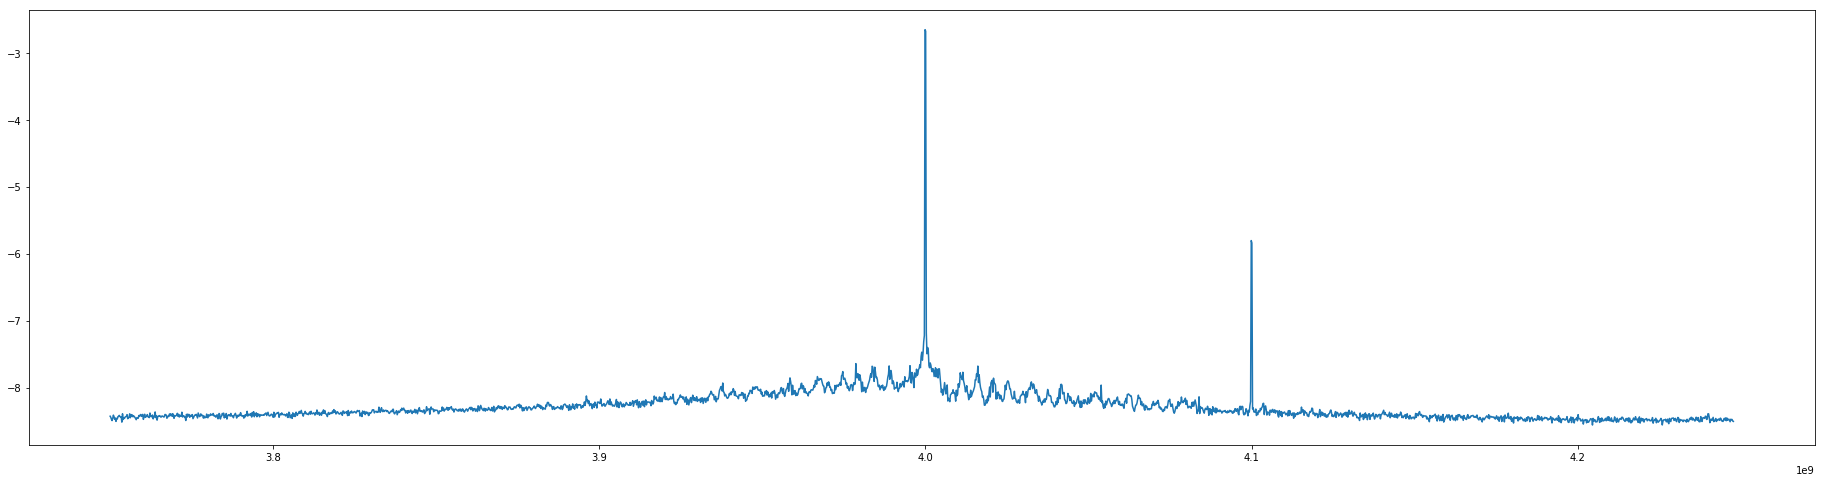

In [40]:
plt.figure(figsize=(32,8))
plt.plot(f, np.log10(power))

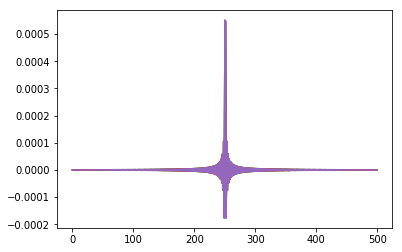

In [48]:
#
plt.plot(iq_calibration_measure_inst.psds.T)
plt.show()

In [11]:

# following numbers ust be integer
#segment_length = int(discretization_frequency/algorithmic_resolution)
#half_physical_padding = int(((discretization_frequency/measurement_resolution_bw*physical_overhead)-segment_length)/2)
#half_simulation_padding = int(((discretization_frequency/measurement_resolution_bw)-segment_length)/2)

In [ ]:
reference_frequency = lo.get_frequency()

In [22]:
random_iq_waveforms = np.random.rand(random_waveform_number, segment_length)+\
                   1j*np.random.rand(random_waveform_number, segment_length)
padded_waveforms    = np.zeros((random_waveform_number, half_physical_padding*2+segment_length), dtype=np.complex)
padded_waveforms[:, half_physical_padding:-half_physical_padding] = random_iq_waveforms

In [33]:
# algorithm:
# 1) measure background
set_waveform(np.zeros_like(padded_waveforms[0, :]))
background = measure_psd()
# 2) at low amplitude, measure real, imag, realimag
psds_low_i = np.zeros((random_waveform_number, int(discretization_frequency/measurement_resolution_bw)))
psds_low_q = np.zeros((random_waveform_number, int(discretization_frequency/measurement_resolution_bw)))
psds_low_iq = np.zeros((random_waveform_number, int(discretization_frequency/measurement_resolution_bw)))
for random_waveform_id in range(random_iq_waveforms.shape[0]):
    set_waveform(low_amplitude*np.real(padded_waveforms[random_waveform_id, :]))
    psd_low_i[random_waveform_id, :]  = measure_psd()
    set_waveform(low_amplitude*np.imag(padded_waveforms[random_waveform_id, :]))
    psd_low_q[random_waveform_id, :]  = measure_psd()
    set_waveform(low_amplitude*padded_waveforms[random_waveform_id, :])
    psd_low_iq[random_waveform_id, :] = measure_psd()

psds_low_i_nobg = psds_low_i-background
psds_low_q_nobg = psds_low_q-background
psds_low_iq_nobg = psds_low_iq-background
psds_low_i_nobg[psds_low_i_nobg<0] = 0
psds_low_q_nobg[psds_low_q_nobg<0] = 0
psds_low_iq_nobg[psds_low_iq_nobg<0] = 0
fd_low_i = np.sqrt(psds_low_i_nobg)
fd_low_q = np.sqrt(psds_low_q_nobg)
fd_low_iq = np.sqrt(psds_low_iq_nobg)

psds_low_iq_interference = psds_low_iq_nobg-psds_low_i_nobg-psds_low_q_nobg

NameError: name 'set_waveform' is not defined

In [35]:
response_i_abs = np.sqrt(np.sum(psds_low_i_nobg, axis=0)/np.sum(np.abs(dft(np.real(padded_waveforms)))**2), axis=0)/low_amplitude
response_q_abs = np.sqrt(np.sum(psds_low_q_nobg, axis=0)/np.sum(np.abs(dft(np.imag(padded_waveforms)))**2), axis=0)/low_amplitude
fd_low_i_sim = dft(np.real(padded_waveforms))*response_i_abs
fd_low_q_sim = 1j*dft(np.imag(padded_waveforms))*response_q_abs

NameError: name 'psds_low_i_nobg' is not defined

In [38]:
iq_phase = np.ones(response_i_abs.shape, dtype=np.complex)
phase_retrieval_iterations = 5
for phase_retrieval_iteration in range(phase_retrieval_iterations):
    psds_low_iq_interference_simulation = fd_low_i_sim*np.conj(fd_low_q_sim*iq_phase)
    response_iq_interference_simulation = psds_low_iq_interference + 1j*np.imag(psds_low_iq_interference_simulation)
    iq_phase = np.sum(response_iq_interference_simulation_corrected*np.conj(fd_low_i_sim)*fd_low_q_sim, axis=0)
    iq_phase = np.exp(1j*np.angle(iq_phase))
    
linear_response_i = response_i_abs
linear_response_q = response_q_abs*iq_phase

NameError: name 'response_i_abs' is not defined

In [3]:
class linear_model:
    def __init__(self, waveforms, psds_sqrt, update_rate=0.7):
        self.waveforms = waveforms
        self.response_i = np.ones(waveforms.shape[1], dtype=np.complex)
        self.response_q = np.ones(waveforms.shape[1], dtype=np.complex)
        self.psds_sqrt = psds_sqrt
        self.update_rate = update_rate
        self.forward()
    def forward(self):
        self.waveforms_i_fd = dft(np.real(self.waveforms))
        self.waveforms_q_fd = dft(np.imag(self.waveforms))
        self.model = self.waveforms_i_fd*self.response_i+1j*self.wavefroms_q_fd*self.response_q
        return self.model
    def apply_measurement_constraint(self):
        self.measurement_constrained_model = np.exp(1j*self.model)*self.psds_sqrt
        self.model_diff = self.measurement_constrained_model-self.model
    def backward_projection(self):
        waveform_i_norm = np.sum(np.abs(self.waveforms_i_fd)**2) # sure about this axis?? axis=0)
        waveform_q_norm = np.sum(np.abs(self.waveforms_q_fd)**2)
        self.response_i += update_rate*np.sum(self.model_diff*np.conj(dft(np.real(self.waveforms))), axis=0)/waveform_i_norm
        self.response_q += update_rate*np.sum(self.model_diff*np.conj(1j*dft(np.imag(self.waveforms))), axis=0)/waveform_q_norm
    def evaluate_mse_model(self):
        self.mse_model = np.std(np.abs(self.model_diff))**2
    def iterate(self, iteration_num):
        for iteration in range(iteration_num):
            self.forward()
            self.apply_measurement_constraint()
            self.evaluate_mse_model()
            print ('Iteration: {} MSE model: {}'.format(iteration, self.mse_model))
            self.backward_projection()

In [ ]:
class nonlinear_instanteneous_model(linear_model):
    def __init__(self, wavefroms, psds_sqrt, update_rate=0.7):
        super().__init__(waveforms, psdssqrt, update_rate)
        self.response_i_

In [ ]:
nonlinear_coefs = [(1,1), (2,0), (0,2), (2,1), (1,2), (3,0), (0,3)]

def response_low_freqeuncy(waveform, response):
    return np.real(np.ift(np.dft(waveform)*response))

def instant_nonlinear_model(waveform, nonlinear_coefs):
    waveform

def background(waveform, background)

def full_instant_model_fd(waveform, response_i, response_q, bg, coefs, response_post_mixer):
    wave